# Scenario 3 B

* Use random forest classifier to predict LogSalePrice. 
* Use features selected by Lasso and SequentialFeatureSelector
* Implement ordinal encoding

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
# Load the data
df = pd.read_csv(
    "../data/ames_housing_clean_1.csv",
    keep_default_na=False,  
    na_values=["", " "],
    dtype={'MSSubClass': 'str'}
)

In [ ]:
# Define the features to use
selected_features = {
    'BldgType', 'BsmtExposure', 'BsmtFinSF1', 'BsmtQual', 'Condition2', 
    'ExterCond', 'ExterQual', 'Exterior1st', 'Functional', 'GarageArea', 
    'GarageCond', 'GrLivArea', 'KitchenQual', 'MSSubClass', 'MSZoning', 
    'MasVnrArea', 'Neighborhood', 'OverallCond', 'OverallQual', 'RoofMatl', 
    'SaleCondition', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd'
}

df['LogSalePrice'] = np.log(df['SalePrice'])

# Create feature matrix and target variable
X = df[list(selected_features)]
y = df['LogSalePrice']

print(f"\nFeature matrix shape: {X.shape}")

In [ ]:
# Check for missing values
print(f"\nMissing values in features:")
missing_vals = X.isnull().sum()
print(missing_vals[missing_vals > 0])

In [ ]:
# Manually specify the categories for ordinal encoding according to the data dictionary
ordinal_order = {
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the quality of the material on the exterior
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the present condition of the material on the exterior
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Height of the basement
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],  # Walkout or garden level basement walls
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Kitchen quality
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Home functionality
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']  # Garage condition
}
 
# Extract list of ALL ordinal features from dictionary
ordinal_features = list(ordinal_order.keys())

In [ ]:
# Identify numeric and categorical and nominal columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
nominal_features = [feature for feature in categorical_features if feature not in ordinal_features]

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
# print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Nominal features ({len(nominal_features)}): {nominal_features}")
print(f"Ordinal features ({len(ordinal_features)}): {ordinal_features}")

In [32]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('ordinal', OrdinalEncoder(categories=[ordinal_order[feature] for feature in ordinal_features]), ordinal_features),
        ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ]
)

In [34]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 2060
Test set size: 516


In [35]:
# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed feature matrix shape: {X_train_processed.shape}")

Processed feature matrix shape: (2060, 104)


In [36]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Define hyperparameter grid for tuning
param_grid = {
    'max_depth': range(1, 31, 5),
    'n_estimators': range(20, 220, 20)
}


In [37]:
print("\n=== HYPERPARAMETER TUNING WITH GRIDSEARCHCV ===")
# Perform grid search with cross-validation
grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
print("Training models with different hyperparameter combinations...")
grid_search.fit(X_train_processed, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV R² score: {grid_search.best_score_:.4f}")


=== HYPERPARAMETER TUNING WITH GRIDSEARCHCV ===
Training models with different hyperparameter combinations...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'max_depth': 26, 'n_estimators': 140}
Best CV R² score: 0.8841


In [38]:
# Use the best model
rf_model = grid_search.best_estimator_

# Make predictions with the best model
print(f"\nMaking predictions with best model:")
print(f"Best model parameters: {rf_model.get_params()}")
y_train_pred = rf_model.predict(X_train_processed)
y_test_pred = rf_model.predict(X_test_processed)

# Calculate metrics for log scale
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\n=== MODEL PERFORMANCE (Log Scale) ===")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Making predictions with best model:
Best model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 26, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 140, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

=== MODEL PERFORMANCE (Log Scale) ===
Training R²: 0.9841
Test R²: 0.9069
Training RMSE: 0.0489
Test RMSE: 0.1175
Training MAE: 0.0322
Test MAE: 0.0863


In [39]:
# Feature importance analysis
# Get feature names after preprocessing
numeric_feature_names = numeric_features
ordinal_feature_names = ordinal_features
nominal_encoder = preprocessor.named_transformers_['nominal']  
nominal_feature_names = nominal_encoder.get_feature_names_out(nominal_features).tolist()
all_feature_names = numeric_feature_names + ordinal_feature_names + nominal_feature_names

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== TOP 20 FEATURE IMPORTANCES ===")
print(feature_importance.head(20))



=== TOP 20 FEATURE IMPORTANCES ===
                   feature  importance
1              OverallQual    0.556768
4                GrLivArea    0.127679
5               GarageArea    0.097905
6              TotalBsmtSF    0.061653
3               BsmtFinSF1    0.028571
7                YearBuilt    0.022422
8             YearRemodAdd    0.014280
2              OverallCond    0.011635
11                BsmtQual    0.009067
0               MasVnrArea    0.008875
93             MSZoning_RM    0.006012
12            BsmtExposure    0.003709
13             KitchenQual    0.003660
10               ExterCond    0.003305
15              GarageCond    0.002999
9                ExterQual    0.002935
49    Neighborhood_Crawfor    0.002208
92             MSZoning_RL    0.002020
98   SaleCondition_Abnorml    0.001995
102   SaleCondition_Normal    0.001908


In [40]:
# Cross-validation with best model
cv_scores = cross_val_score(rf_model, X_train_processed, y_train, cv=5, scoring='r2')
print(f"\n=== CROSS-VALIDATION RESULTS (BEST MODEL) ===")
print(f"CV R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")
print(f"Std CV R²: {cv_scores.std():.4f}")



=== CROSS-VALIDATION RESULTS (BEST MODEL) ===
CV R² scores: [0.83969745 0.9091739  0.8992361  0.87814308 0.89445273]
Mean CV R²: 0.8841
Std CV R²: 0.0244


In [41]:
# Additional grid search results analysis
print(f"\n=== GRID SEARCH ANALYSIS ===")
results_df = pd.DataFrame(grid_search.cv_results_)
print(f"Top 5 parameter combinations:")
top_results = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_results.iterrows():
    print(f"  {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f}): {row['params']}")




=== GRID SEARCH ANALYSIS ===
Top 5 parameter combinations:
  0.8841 (±0.0244): {'max_depth': 26, 'n_estimators': 140}
  0.8841 (±0.0249): {'max_depth': 26, 'n_estimators': 100}
  0.8841 (±0.0242): {'max_depth': 21, 'n_estimators': 140}
  0.8841 (±0.0246): {'max_depth': 16, 'n_estimators': 100}
  0.8840 (±0.0244): {'max_depth': 26, 'n_estimators': 180}


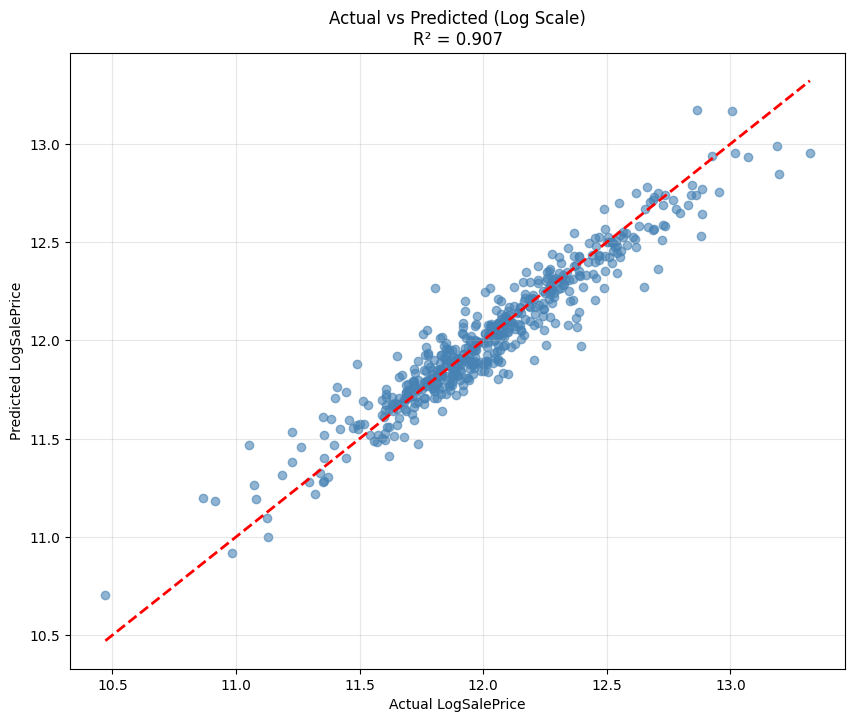

In [42]:
# Actual vs Predicted (Log Scale)
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual LogSalePrice')
plt.ylabel('Predicted LogSalePrice')
plt.title(f'Actual vs Predicted (Log Scale)\nR² = {test_r2:.3f}')
plt.grid(True, alpha=0.3)


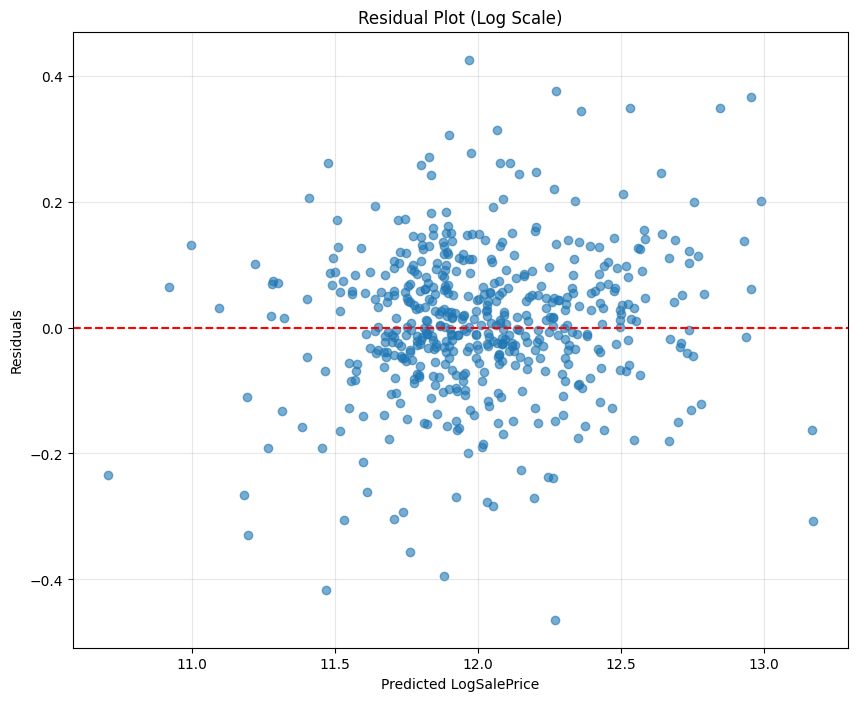

In [43]:
# Residuals (Log Scale)
plt.figure(figsize=(10, 8))
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted LogSalePrice')
plt.ylabel('Residuals')
plt.title('Residual Plot (Log Scale)')
plt.grid(True, alpha=0.3)

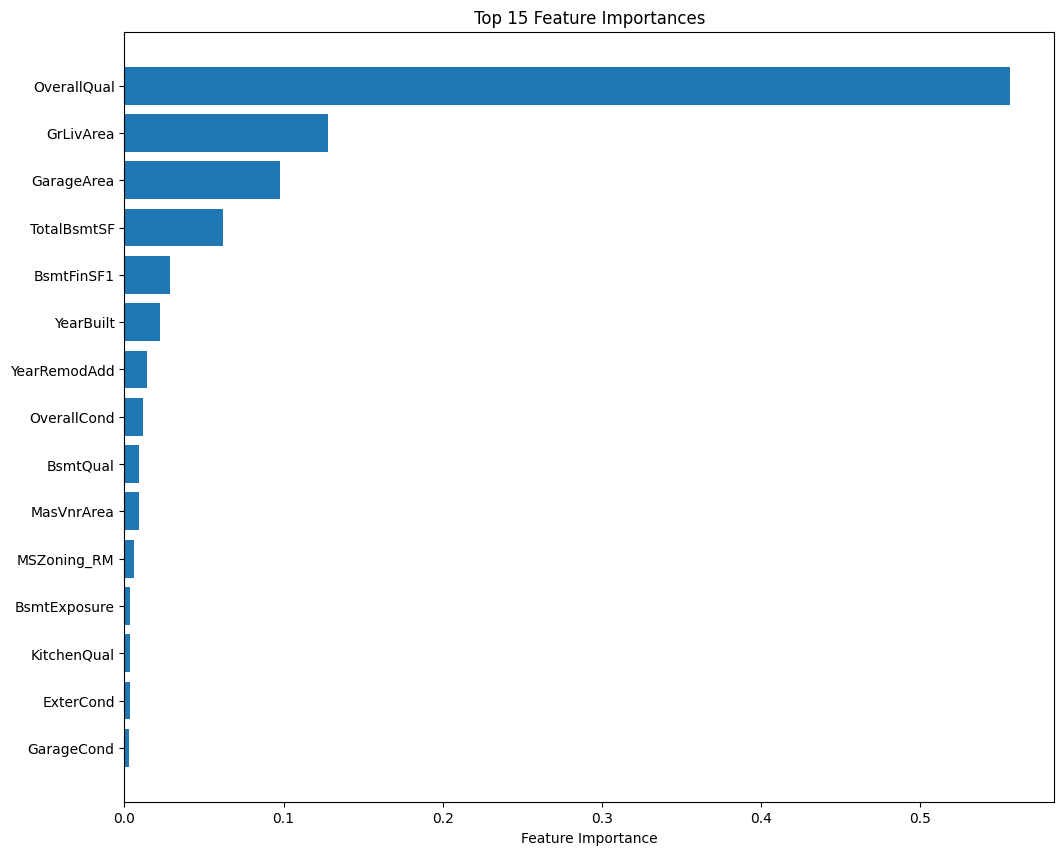

In [44]:
# Feature Importance (Top 15)
plt.figure(figsize=(12, 10))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'])
plt.yticks(range(len(top_15)), [f[:25] + '...' if len(f) > 25 else f for f in top_15['feature']])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()

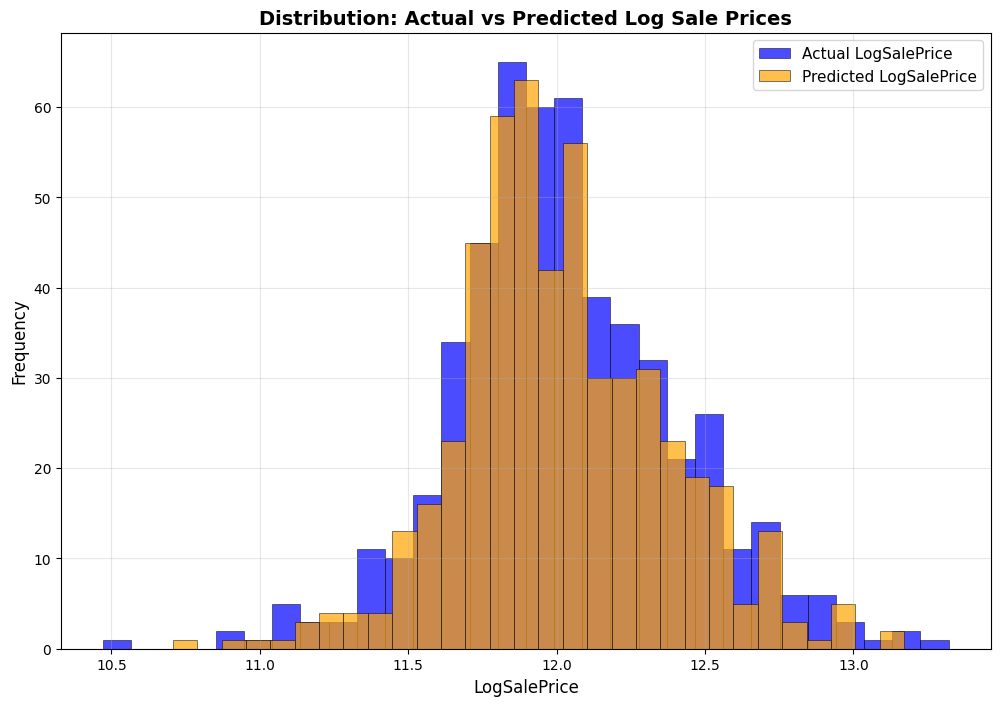

In [48]:
# Prediction distribution plot on log scale
plt.figure(figsize=(12, 8))

# Create histograms for actual and predicted log prices
plt.hist(y_test, alpha=0.7, label='Actual LogSalePrice', bins=30, color='blue', edgecolor='black', linewidth=0.5)
plt.hist(y_test_pred, alpha=0.7, label='Predicted LogSalePrice', bins=30, color='orange', edgecolor='black', linewidth=0.5)

# # Add vertical lines for means
# plt.axvline(y_test.mean(), color='blue', linestyle='--', linewidth=2, alpha=0.8, label=f'Actual Mean: {y_test.mean():.3f}')
# plt.axvline(y_test_pred.mean(), color='orange', linestyle='--', linewidth=2, alpha=0.8, label=f'Predicted Mean: {y_test_pred.mean():.3f}')

# Formatting
plt.xlabel('LogSalePrice', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution: Actual vs Predicted Log Sale Prices', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)